In [1]:
import sys 
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass 

from physics.fom import sensitivity, sfm, mcf, tsf 
from physics.reflectometry import _kz, reflectivity

from problems.base1 import Bounds, SOISpec, CapSpec, MRL, Materials, Base1OptimizationProblem, SubstrateSpec
from data.materials_loader import load_base1_materials


/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:68: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  # x_coti \in [0,1]
/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:124: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  - x_coti \in [bounds_x.lo, bounds_x.hi]


In [ ]:
from physics.reflectometry import reflectivity as refl

def plot_fig1_like(problem: Base1OptimizationProblem,
                   soi: SOISpec,
                   x_coti: float,
                   d_mrl: float,
                   d_cap: float,
                   cap: str,
                   bkg: float = 1e-3,
                   title_suffix: str = ""):
    Q = problem.Q
    sub = problem.materials.substrate

    # Non polarized SOI on substrate
    layers_np = [
        {"rho": soi.rho_n, "thickness": soi.thickness, "sigma": soi.sigma},
        {"rho": sub.rho_n, "thickness": 0.0,           "sigma": 0.0},
    ]
    R_np = refl(Q, layers_np, bkg=bkg)

    # spin resolved stacks from Base1
    res_with_soi = problem.analyze_single_soi(
        soi, x_coti, d_mrl, d_cap, cap, bkg=bkg
    )

    # MRL only: build stacks without SOI  
    layers_mrl_up, layers_mrl_dn = problem._layers(
        x_coti=x_coti, d_mrl=d_mrl, d_cap=d_cap, cap=cap, soi=None
    )
    R_mrl_up = problem._reflect(Q, layers_mrl_up, bkg=bkg)
    R_mrl_dn = problem._reflect(Q, layers_mrl_dn, bkg=bkg)

    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

    # SOI + substrate
    ax = axes[0]
    ax.semilogy(Q, R_np, label="Non-polarized")
    ax.set_xlabel(r"Q ($\AA^{-1}$)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.set_title("(a) SOI + substrate" + title_suffix)
    ax.set_xlim(0.0, 0.07)

    # MRL on substrate
    ax = axes[1]
    ax.semilogy(Q, R_mrl_up, label="Spin-up")
    ax.semilogy(Q, R_mrl_dn, label="Spin-down")
    ax.set_title("(b) MRL on substrate" + title_suffix)
    ax.set_xlabel(r"Q ($\AA^{-1}$)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.legend()
    ax.set_xlim(0.0, 0.07)

    # SOI on MRL on substrate
    ax = axes[2]
    ax.semilogy(Q, res_with_soi["Rfull_up"], label="Spin-up")
    ax.semilogy(Q, res_with_soi["Rfull_dn"], label="Spin-down")
    ax.set_title("(c) SOI on MRL on substrate" + title_suffix)
    ax.set_xlabel(r"Q ($\AA^{-1}$)")
    ax.set_ylabel("Intensity (a.u.)")
    ax.legend()
    ax.set_xlim(0.0, 0.07)

    fig.tight_layout()
    return fig, axes


In [ ]:
def plot_sensitivity_grid(problem: Base1OptimizationProblem,
                          x_coti: float,
                          d_mrl: float,
                          d_cap: float,
                          cap: str,
                          soi_list: list[SOISpec],
                          title_prefix: str = ""):
    """
    Make a 1xN row of sensitivity plots 

    `soi_list` should be [normal_sld1, normal_sld2, normal_sld3] 
    """
    n = len(soi_list)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3), sharex=True, sharey=True)

    if n == 1:
        axes = [axes]

    total_triplets = []

    for ax, soi in zip(axes, soi_list):
        res = problem.analyze_single_soi(
            soi=soi,
            x_coti=x_coti,
            d_mrl=d_mrl,
            d_cap=d_cap,
            cap=cap,
            bkg=0.0,
        )
        Q = res["Q"]
        S_up = res["S_up"]
        S_dn = res["S_dn"]

        ax.plot(Q, S_up, label="Spin-up")
        ax.plot(Q, S_dn, label="Spin-down")
        ax.axhline(0.0, color="k", linewidth=0.5)
        ax.set_xlabel(r"Q ($\AA^{-1}$)")
        ax.set_title(f"{title_prefix} {soi.name}\n"
                     f"SFM↑={res['SFM_up']:.3f}, "
                     f"SFM↓={res['SFM_dn']:.3f}, "
                     f"MCF={res['MCF']:.3f}")

        total_triplets.append((res["SFM_up"], res["SFM_dn"], res["MCF"]))

    axes[0].set_ylabel("Sensitivity")
    axes[0].legend(loc="upper right")

    # TSF for the row – printed in the figure suptitle
    row_tsf = tsf(total_triplets)
    fig.suptitle(f"TSF = {row_tsf:.3f}", y=1.02)

    fig.tight_layout()


In [ ]:
# Q grid
Q = np.linspace(0.002, 0.28, 800)

# ---- substrate ----
substrate = SubstrateSpec(
    name="Si",
    rho_n=2.07e-6,   # Å^-2
    sigma=3.0        # Å
)

# ---- SOIs ----
sois: list[SOISpec] = [
    # normal, thickness 500 Å, sigma 15 Å
    SOISpec("normal_rho1", rho_n=1.0e-6, thickness=500.0, sigma=15.0),
    SOISpec("normal_rho2", rho_n=2.0e-6, thickness=500.0, sigma=15.0),
    SOISpec("normal_rho3", rho_n=3.0e-6, thickness=500.0, sigma=15.0),

    # rough, 500 Å, sigma 50 Å
    SOISpec("rough_rho1",  rho_n=1.0e-6, thickness=500.0, sigma=50.0),
    SOISpec("rough_rho2",  rho_n=2.0e-6, thickness=500.0, sigma=50.0),
    SOISpec("rough_rho3",  rho_n=3.0e-6, thickness=500.0, sigma=50.0),

    # thin, 50 Å, sigma 15 Å
    SOISpec("thin_rho1",   rho_n=1.0e-6, thickness=50.0,  sigma=15.0),
    SOISpec("thin_rho2",   rho_n=2.0e-6, thickness=50.0,  sigma=15.0),
    SOISpec("thin_rho3",   rho_n=3.0e-6, thickness=50.0,  sigma=15.0),
]

# convenience for just the "normal" SOIs in order ro = 1,2,3
normal_sois = sorted(
    [s for s in sois if s.name.startswith("normal_")],
    key=lambda s: s.rho_n
)
soi_normal_rho2 = [s for s in normal_sois if np.isclose(s.rho_n, 2e-6)][0]

# ---- MRLs ----

# CoTi MRL
rho_n_Co = 2.3e-6
rho_n_Ti = -1.9e-6
rho_m_Co = 3.9e-6  # mSLD for pure Co

def m_sld_from_x(x: float) -> float:
    # simple scaling with Co fraction
    return x * rho_m_Co

mrl_coti = MRL(
    rho_n_Co=rho_n_Co,
    rho_n_Ti=rho_n_Ti,
    m_sld_from_x=m_sld_from_x,
    sigma_sub_mrl=5.0,
    sigma_mrl_cap=5.0,
)

# Fe / Ni constant MRLs 
def make_constant_mrl(rho_n: float, rho_m: float) -> MRL:
    def m_const(x: float, rm=rho_m) -> float:
        return rm
    return MRL(
        rho_n_Co=rho_n,
        rho_n_Ti=rho_n,     # same => nuclear SLD independent of x
        m_sld_from_x=m_const,
        sigma_sub_mrl=5.0,
        sigma_mrl_cap=5.0,
    )

mrl_fe = make_constant_mrl(8.0e-6, 5.0e-6)
mrl_ni = make_constant_mrl(9.4e-6, 1.0e-6)

# ---- caps ----
caps = {
    "none":  CapSpec(name="none",  nom_thickness=0.0,  rho_n=0.0,   sigma=5.0),
    "Al2O3": CapSpec(name="Al2O3", nom_thickness=16.0, rho_n=4e-6,  sigma=5.0),
}

# ---- bounds for optimization variables (used by Base1) ----
bounds_x = Bounds(0.0, 1.0)
bounds_d = Bounds(10.0, 200.0)
bounds_cap = Bounds(0.0, 40.0)

# ---- Materials & Base1 problems for each MRL ----
materials_fe = Materials(substrate=substrate, caps=caps, mrl=mrl_fe)
materials_ni = Materials(substrate=substrate, caps=caps, mrl=mrl_ni)
materials_coti = Materials(substrate=substrate, caps=caps, mrl=mrl_coti)

problem_fe = Base1OptimizationProblem(materials_fe, sois, Q, bounds_x, bounds_d, bounds_cap)
problem_ni = Base1OptimizationProblem(materials_ni, sois, Q, bounds_x, bounds_d, bounds_cap)
problem_coti = Base1OptimizationProblem(materials_coti, sois, Q, bounds_x, bounds_d, bounds_cap)

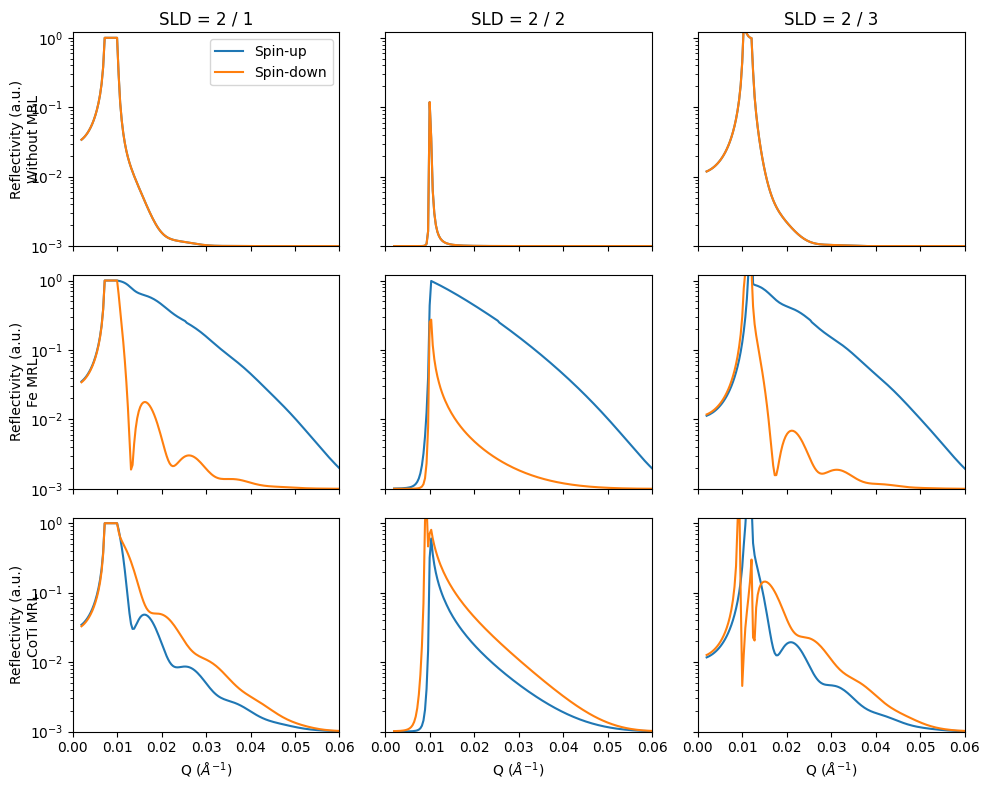

In [ ]:

# Paper parameters for the SOI
th1, sig1, rho_bottom = 500.0, 15.0, 2.0e-6   # gamma1, sogma1, SLD_bottom = 2
th2, sig2 = 200.0, 50.0           # Λ2, σ2
rho_top_vals = [1.0e-6, 2.0e-6, 3.0e-6]  # SLD of gamma2 (top) = 1,2,3

d_mrl = 100.0  # Å (not in paper)
x_fe = 1.0     # Fe MRL: nuclear SLD & mSLD independent of x
x_coti = 0.73  # CoTi composition, same as before

bkg = 1e-3

def build_two_layer_soi(rho_top: float):
    """Two-layer SOI on Si, no MRL."""
    return [
        {"rho": rho_top,     "thickness": th2, "sigma": sig2},   # top Gamma2
        {"rho": rho_bottom,  "thickness": th1, "sigma": sig1},   # bottom Gamma1
        {"rho": substrate.rho_n, "thickness": 0.0, "sigma": substrate.sigma},
    ]

def build_two_layer_with_mrl(rho_top: float, mrl: MRL, x: float, d_mrl: float):
    """
    Two-layer SOI + magnetic MRL (Fe or CoTi) on Si.
    Returns (layers_up, layers_down).
    """
    # base (non-magnetic) part: two SOI layers
    base = [
        {"rho": rho_top,     "thickness": th2, "sigma": sig2},
        {"rho": rho_bottom,  "thickness": th1, "sigma": sig1},
    ]

    # MRL nuclear + magnetic SLD
    rho_n_mrl = x * mrl.rho_n_Co + (1.0 - x) * mrl.rho_n_Ti
    rho_m_mrl = float(mrl.m_sld_from_x(x))
    rho_up = rho_n_mrl + rho_m_mrl
    rho_dn = rho_n_mrl - rho_m_mrl

    layers_up = base + [
        {"rho": rho_up, "thickness": d_mrl, "sigma": mrl.sigma_mrl_cap},
        {"rho": substrate.rho_n, "thickness": 0.0, "sigma": mrl.sigma_sub_mrl},
    ]

    layers_dn = base + [
        {"rho": rho_dn, "thickness": d_mrl, "sigma": mrl.sigma_mrl_cap},
        {"rho": substrate.rho_n, "thickness": 0.0, "sigma": mrl.sigma_sub_mrl},
    ]

    return layers_up, layers_dn

fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)

row_labels = ["Without MRL", "Fe MRL", "CoTi MRL"]
col_labels = ["SLD = 2 / 1", "SLD = 2 / 2", "SLD = 2 / 3"]

for col, rho_top in enumerate(rho_top_vals):
    # ----- Without MRL -----
    ax = axes[0, col]
    layers = build_two_layer_soi(rho_top)
    R = refl(Q, layers, bkg=bkg)

    # no magnetism => spin up & down are identical, but we plot both
    ax.semilogy(Q, R, label="Spin-up")
    ax.semilogy(Q, R, label="Spin-down")
    ax.set_xlim(0.0, 0.06)
    ax.set_ylim(1e-3, 1)

    # ----- Fe MRL -----
    ax = axes[1, col]
    layers_up, layers_dn = build_two_layer_with_mrl(rho_top, mrl_fe, x_fe, d_mrl)
    R_up = refl(Q, layers_up, bkg=bkg)
    R_dn = refl(Q, layers_dn, bkg=bkg)
    ax.semilogy(Q, R_up, label="Spin-up")
    ax.semilogy(Q, R_dn, label="Spin-down")
    ax.set_xlim(0.0, 0.06)
    ax.set_ylim(1e-3, 1)

    # ----- CoTi MRL -----
    ax = axes[2, col]
    layers_up, layers_dn = build_two_layer_with_mrl(rho_top, mrl_coti, x_coti, d_mrl)
    R_up = refl(Q, layers_up, bkg=bkg)
    R_dn = refl(Q, layers_dn, bkg=bkg)
    ax.semilogy(Q, R_up, label="Spin-up")
    ax.semilogy(Q, R_dn, label="Spin-down")
    ax.set_xlim(0.0, 0.06)
    ax.set_ylim(1e-3, 1.2)

# Column titles
for col, label in enumerate(col_labels):
    axes[0, col].set_title(label)

# Row labels on the left
for row, label in enumerate(row_labels):
    axes[row, 0].set_ylabel("Reflectivity (a.u.)")
    axes[row, 0].text(
        -0.12, 0.5, label,
        transform=axes[row, 0].transAxes,
        rotation=90, va="center", ha="right",
    )

# Bottom x-labels
for ax in axes[-1, :]:
    ax.set_xlabel(r"Q ($\AA^{-1}$)")

# Legend in top-left panel
axes[0, 0].legend(loc="upper right")

fig.tight_layout()
plt.show()


plt.show()


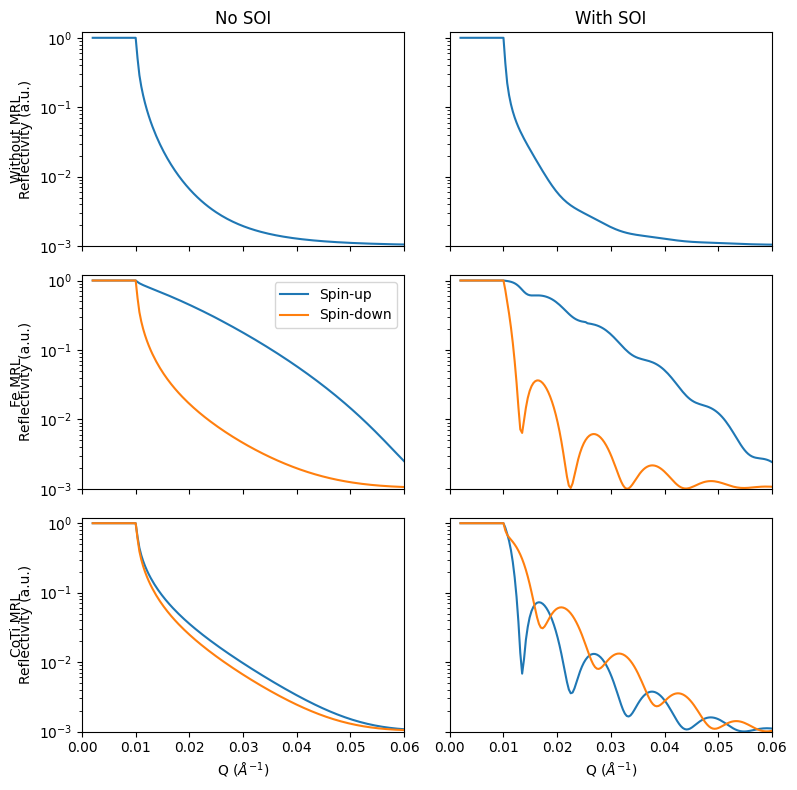

In [ ]:
# SOI parameters for this figure 
soi_thickness = 500.0  # Å
soi_sigma = 15.0     # Å
soi_rho = 2.0e-6   # SLD = 2 × 10^-6 Å^-2

# MRL parameters
d_mrl_fe = 100.0       # Å  
d_mrl_coti = 100.0       # Å
x_fe = 1.0         # Fe MRL
x_coti = 0.73        # Co0.73Ti0.27

# background from the paper
bkg = 1e-3

def air_layer():
    """Top medium: air/vacuum."""
    return {"rho": 0.0, "thickness": 0.0, "sigma": 0.0}

def mrl_slds(mrl: MRL, x: float) -> tuple[float, float]:
    rho_n = x * mrl.rho_n_Co + (1.0 - x) * mrl.rho_n_Ti
    rho_m = float(mrl.m_sld_from_x(x))
    return rho_n + rho_m, rho_n - rho_m

def stack_substrate_only():
    # air | Si
    return [
        air_layer(),
        {"rho": substrate.rho_n, "thickness": 0.0, "sigma": substrate.sigma},
    ]

def stack_soi_on_substrate():
    # air | SOI | Si
    return [
        air_layer(),
        {"rho": soi_rho,          "thickness": soi_thickness, "sigma": soi_sigma},
        {"rho": substrate.rho_n,  "thickness": 0.0,           "sigma": substrate.sigma},
    ]

def stack_mrl_on_substrate(mrl: MRL, x: float, d_mrl: float, spin: str):
    rho_up, rho_dn = mrl_slds(mrl, x)
    rho = rho_up if spin == "up" else rho_dn
    # air | MRL | Si
    return [
        air_layer(),
        {"rho": rho, "thickness": d_mrl, "sigma": mrl.sigma_mrl_cap},
        {"rho": substrate.rho_n,  "thickness": 0.0, "sigma": mrl.sigma_sub_mrl},
    ]

def stack_soi_on_mrl(mrl: MRL, x: float, d_mrl: float, spin: str):
    rho_up, rho_dn = mrl_slds(mrl, x)
    rho = rho_up if spin == "up" else rho_dn
    # air | SOI | MRL | Si
    return [
        air_layer(),
        {"rho": soi_rho,          "thickness": soi_thickness,  "sigma": soi_sigma},
        {"rho": rho,              "thickness": d_mrl,          "sigma": mrl.sigma_mrl_cap},
        {"rho": substrate.rho_n,  "thickness": 0.0,            "sigma": mrl.sigma_sub_mrl},
    ]

fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)

row_labels = ["Without MRL", "Fe MRL", "CoTi MRL"]
col_labels = ["No SOI", "With SOI"]

# ---------------- no MRL ----------------
# substrate only
ax = axes[0, 0]
layers = stack_substrate_only()
R = refl(Q, layers, bkg=bkg)
ax.semilogy(Q, R, label="Non-polarized")
ax.set_xlim(0.0, 0.06)
ax.set_ylim(1e-3, 1.0)

# SOI on substrate
ax = axes[0, 1]
layers = stack_soi_on_substrate()
R = refl(Q, layers, bkg=bkg)
ax.semilogy(Q, R, label="Non-polarized")
ax.set_xlim(0.0, 0.06)
ax.set_ylim(1e-3, 1.0)

# ---------------- Fe MRL ----------------
ax = axes[1, 0]
layers_up = stack_mrl_on_substrate(mrl_fe, x_fe, d_mrl_fe, "up")
layers_dn = stack_mrl_on_substrate(mrl_fe, x_fe, d_mrl_fe, "down")
R_up = refl(Q, layers_up, bkg=bkg)
R_dn = refl(Q, layers_dn, bkg=bkg)
ax.semilogy(Q, R_up, label="Spin-up")
ax.semilogy(Q, R_dn, label="Spin-down")
ax.set_xlim(0.0, 0.06)
ax.set_ylim(1e-3, 1.2)

ax = axes[1, 1]
layers_up = stack_soi_on_mrl(mrl_fe, x_fe, d_mrl_fe, "up")
layers_dn = stack_soi_on_mrl(mrl_fe, x_fe, d_mrl_fe, "down")
R_up = refl(Q, layers_up, bkg=bkg)
R_dn = refl(Q, layers_dn, bkg=bkg)
ax.semilogy(Q, R_up, label="Spin-up")
ax.semilogy(Q, R_dn, label="Spin-down")
ax.set_xlim(0.0, 0.06)
ax.set_ylim(1e-3, 1.2)

# ---------------- CoTi MRL ----------------
ax = axes[2, 0]
layers_up = stack_mrl_on_substrate(mrl_coti, x_coti, d_mrl_coti, "up")
layers_dn = stack_mrl_on_substrate(mrl_coti, x_coti, d_mrl_coti, "down")
R_up = refl(Q, layers_up, bkg=bkg)
R_dn = refl(Q, layers_dn, bkg=bkg)
ax.semilogy(Q, R_up, label="Spin-up")
ax.semilogy(Q, R_dn, label="Spin-down")
ax.set_xlim(0.0, 0.06)
ax.set_ylim(1e-3, 1.2)

ax = axes[2, 1]
layers_up = stack_soi_on_mrl(mrl_coti, x_coti, d_mrl_coti, "up")
layers_dn = stack_soi_on_mrl(mrl_coti, x_coti, d_mrl_coti, "down")
R_up = refl(Q, layers_up, bkg=bkg)
R_dn = refl(Q, layers_dn, bkg=bkg)
ax.semilogy(Q, R_up, label="Spin-up")
ax.semilogy(Q, R_dn, label="Spin-down")
ax.set_xlim(0.0, 0.06)
ax.set_ylim(1e-3, 1.2)

# Column titles
for col, label in enumerate(col_labels):
    axes[0, col].set_title(label)

# Row labels
for row, label in enumerate(row_labels):
    axes[row, 0].set_ylabel("Reflectivity (a.u.)")
    axes[row, 0].text(
        -0.18, 0.5, label,
        transform=axes[row, 0].transAxes,
        rotation=90, va="center", ha="right",
    )

# Bottom x labels
for ax in axes[-1, :]:
    ax.set_xlabel(r"Q ($\AA^{-1}$)")

axes[1, 0].legend(loc="upper right")

fig.tight_layout()
plt.show()


## Comments 

We see clearly that the CoTi alt. provides much better and clearer features for the reseracher. For both sin up and spin down.s